In [ ]:
#necessary
import pandas as pd
import numpy as np
#plotting
import matplotlib.pyplot as plt
import seaborn as sns

#NPL
import re
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
#Ml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/MBIT_data/mbti_1.csv')
data=df2.copy()

In [ ]:
df2.describe()

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq,1832,1


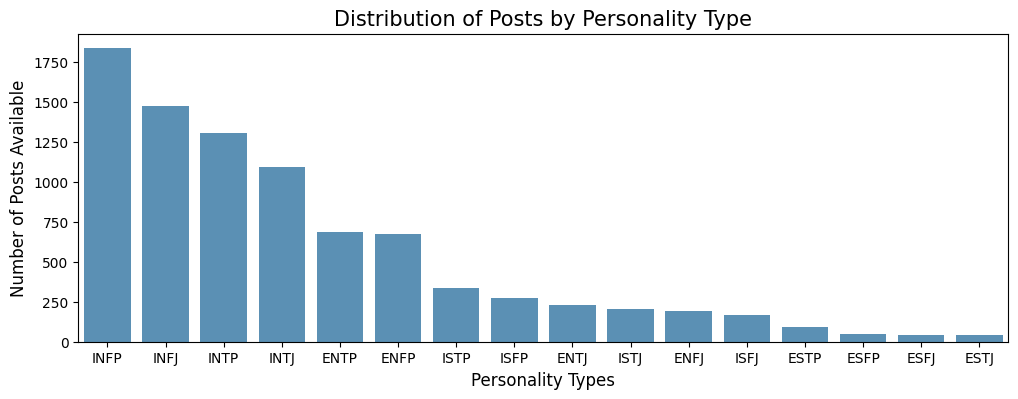

In [ ]:

# Count the occurrences of each type
cnt_srs = df2['type'].value_counts()

# Set the size of the plot
plt.figure(figsize=(12, 4))

# Create the bar plot
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8)

# Set the labels of the plot
plt.xlabel('Personality Types', fontsize=12)
plt.ylabel('Number of Posts Available', fontsize=12)
plt.title('Distribution of Posts by Personality Type', fontsize=15)

# Show the plot
plt.show()


In [ ]:
# MBTI unique types and binary translation dictionaries
unique_type_list = ['infj', 'entp', 'intp', 'intj', 'entj', 'enfj', 'infp', 'enfp', 'istp', 'isfp', 'isfj', 'istj', 'estp', 'esfp', 'estj', 'esfj']
b_Pers = {'I': 0, 'E': 1, 'N': 0, 'S': 1, 'F': 0, 'T': 1, 'J': 0, 'P': 1}
b_Pers_list = [{0: 'I', 1: 'E'}, {0: 'N', 1: 'S'}, {0: 'F', 1: 'T'}, {0: 'J', 1: 'P'}]

def translate_personality(personality):
    # Transform mbti to binary vector
    return [b_Pers[l] for l in personality]

# To show result output for personality prediction
def translate_back(personality):
    # Transform binary vector to mbti personality
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s


In [ ]:
# Define stop words and lemmatizer
useless_words = set(stopwords.words('english'))
lemmatiser = WordNetLemmatizer()

data = df2.copy()

def pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True):
    list_personality = []
    list_posts = []
    len_data = len(data)
    i = 0

    for row in data.iterrows():
        # check code working
        # i+=1
        # if (i % 500 == 0 or i == 1 or i == len_data):
        #     print("%s of %s rows" % (i, len_data))

        # Remove and clean comments
        posts = row[1].posts

        # Remove url links
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)

        # Remove Non-words - keep only words
        temp = re.sub("[^a-zA-Z]", " ", temp)

        # Remove spaces > 1
        temp = re.sub(' +', ' ', temp).lower()

        # Remove multiple letter repeating words
        temp = re.sub(r'([a-z])\1{2,}[\s|\w]*', '', temp)

        # Remove stop words
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in useless_words])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])

        # Remove MBTI personality words from posts
        if remove_mbti_profiles:
            for t in unique_type_list:
                temp = temp.replace(t, "")

        # Transform mbti to binary vector
        type_labelized = translate_personality(row[1].type)  # or use lab_encoder.transform([row[1].type])[0]
        list_personality.append(type_labelized)
        # The cleaned data temp is passed here
        list_posts.append(temp)

    # Returns the result
    list_posts = np.array(list_posts)
    list_personality = np.array(list_personality)
    return list_posts, list_personality

list_posts, list_personality = pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True)

print("Example:")
print("\nPost before preprocessing:\n\n", data.posts.iloc[0])
print("\nPost after preprocessing:\n\n", list_posts[0])
print("\nMBTI before preprocessing:\n\n", data.type.iloc[0])
print("\nMBTI after preprocessing:\n\n", list_personality[0])


Example:

Post before preprocessing:

 'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/upl

In [ ]:
nRow, nCol = list_personality.shape
print(f'No. of posts = {nRow}  and No. of Personalities = {nCol} ')

No. of posts = 8675  and No. of Personalities = 4 


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the vectorizer
tfidf_vectorizer = TfidfVectorizer(
    analyzer="word",
    max_features=1000,
    max_df=0.7,
    min_df=0.1
)

# Fit and transform the list_posts directly to a TF-IDF representation
print("Using TfidfVectorizer:")
X_tfidf = tfidf_vectorizer.fit_transform(list_posts)

# The shape of the TF-IDF matrix
print("Now the dataset size is as below")
print(X_tfidf.shape)

# Feature names
feature_names = tfidf_vectorizer.get_feature_names_out()
print("10 feature names can be seen below")
print(list(enumerate(feature_names[:10])))


Using TfidfVectorizer:
Now the dataset size is as below
(8675, 595)
10 feature names can be seen below
[(0, 'ability'), (1, 'able'), (2, 'absolutely'), (3, 'across'), (4, 'act'), (5, 'action'), (6, 'actually'), (7, 'add'), (8, 'advice'), (9, 'afraid')]


In [ ]:
#counting top 50 words
reverse_dic = {}
for key in tfidf_vectorizer.vocabulary_:
    reverse_dic[tfidf_vectorizer.vocabulary_[key]] = key
top_50 = np.asarray(np.argsort(np.sum(X_tfidf, axis=0))[0,-50:][0, ::-1]).flatten()
[reverse_dic[v] for v in top_50]

['type',
 'feel',
 'friend',
 'love',
 'well',
 'say',
 'want',
 'way',
 'good',
 'something',
 'see',
 'also',
 'lot',
 'go',
 'life',
 'someone',
 'always',
 'even',
 'year',
 'never',
 'could',
 'though',
 'find',
 'thought',
 'need',
 'work',
 'pretty',
 'actually',
 'person',
 'yes',
 'sure',
 'going',
 'right',
 'first',
 'day',
 'feeling',
 'thread',
 'guy',
 'mean',
 'post',
 'take',
 'lol',
 'come',
 'still',
 'said',
 'look',
 'got',
 'many',
 'read',
 'relationship']

In [ ]:
# Initialize personality types
personality_type = [ "IE: Introversion (I) / Extroversion (E)", "NS: Intuition (N) / Sensing (S)",
                   "FT: Feeling (F) / Thinking (T)", "JP: Judging (J) / Perceiving (P)"  ]

for l in range(len(personality_type)):
    print(personality_type[l])

IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) / Sensing (S)
FT: Feeling (F) / Thinking (T)
JP: Judging (J) / Perceiving (P)


In [ ]:
print("X: 1st posts in tf-idf representation\n%s" % X_tfidf[0])
print("\n")

X: 1st posts in tf-idf representation
  (0, 349)	0.059410348139259946
  (0, 489)	0.06502346132069718
  (0, 338)	0.08813151493295181
  (0, 565)	0.041111781914928196
  (0, 52)	0.07087570430581895
  (0, 51)	0.05506308219879645
  (0, 277)	0.09349615314377653
  (0, 481)	0.07466644149972529
  (0, 11)	0.07066064469623083
  (0, 590)	0.04833236437892714
  (0, 485)	0.09843693837709419
  (0, 10)	0.0810547840560131
  (0, 222)	0.08435344092094439
  (0, 340)	0.07177947503220493
  (0, 441)	0.06318281551598931
  (0, 366)	0.06973745829337154
  (0, 261)	0.055577348034995554
  (0, 457)	0.08311160014717112
  (0, 276)	0.07930796829118913
  (0, 433)	0.08968055824148229
  (0, 510)	0.08067849379801398
  (0, 406)	0.09901670503451844
  (0, 450)	0.06642087294200923
  (0, 383)	0.09674118343306329
  (0, 243)	0.056315768105070226
  :	:
  (0, 192)	0.293044846811719
  (0, 499)	0.06869091772866434
  (0, 568)	0.1643469482973132
  (0, 218)	0.05834299082379839
  (0, 171)	0.08435344092094439
  (0, 544)	0.10580776947921257

In [ ]:
print("For MBTI personality type : %s" % translate_back(list_personality[0,:]))
print("Y : Binarized MBTI 1st row: %s" % list_personality[0,:])

For MBTI personality type : INFJ
Y : Binarized MBTI 1st row: [0 0 0 0]


In [ ]:
X = X_tfidf

# Randomforest

In [ ]:
# Convert to array if not already
X = X_tfidf.toarray()

# Loop through each personality type dimension
for l in range(len(personality_type)):
    Y = list_personality[:, l]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

    # Fit model on training data
    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    # Make predictions for test data
    y_pred = model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)

    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))


IE: Introversion (I) / Extroversion (E) Accuracy: 77.56%
NS: Intuition (N) / Sensing (S) Accuracy: 85.52%
FT: Feeling (F) / Thinking (T) Accuracy: 68.38%
JP: Judging (J) / Perceiving (P) Accuracy: 62.16%


In [ ]:
#XGBoost model for MBTI dataset
# Individually training each mbti personlity type
for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = XGBClassifier()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)

    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 75.52%
NS: Intuition (N) / Sensing (S) Accuracy: 85.19%
FT: Feeling (F) / Thinking (T) Accuracy: 67.69%
JP: Judging (J) / Perceiving (P) Accuracy: 61.79%


In [ ]:
# Stocastic Gradient Descent for MBTI dataset
# Individually training each mbti personlity type
for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = SGDClassifier()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)

    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)

    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 77.54%
NS: Intuition (N) / Sensing (S) Accuracy: 86.03%
FT: Feeling (F) / Thinking (T) Accuracy: 72.34%
JP: Judging (J) / Perceiving (P) Accuracy: 64.41%


In [ ]:
# Logistic Regression for MBTI dataset
# Individually training each mbti personlity type
for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)

    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)

    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 77.54%
NS: Intuition (N) / Sensing (S) Accuracy: 86.06%
FT: Feeling (F) / Thinking (T) Accuracy: 72.44%
JP: Judging (J) / Perceiving (P) Accuracy: 64.51%


In [ ]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical  # Use to_categorical instead of np_utils

In [ ]:
# Function to create model
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:

# Loop through each personality type dimension
for l in range(len(personality_type)):
    Y = list_personality[:, l]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # Create model
    model = create_model(X_train.shape[1])

    # Fit model on training data
    model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1, validation_split=0.2)

    # Make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value[0]) for value in y_pred]

    # Evaluate predictions
    accuracy = accuracy_score(y_test, predictions)

    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))


Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.7469 - loss: 0.5776 - val_accuracy: 0.7635 - val_loss: 0.5401
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7630 - loss: 0.5200 - val_accuracy: 0.7635 - val_loss: 0.5209
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7767 - loss: 0.4580 - val_accuracy: 0.7601 - val_loss: 0.5461
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8047 - loss: 0.4257 - val_accuracy: 0.7403 - val_loss: 0.5683
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8660 - loss: 0.3392 - val_accuracy: 0.7137 - val_loss: 0.6183
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9219 - loss: 0.2283 - val_accuracy: 0.6827 - val_loss: 0.7326
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9662 - loss: 0.1195 - val_accuracy: 0.7266 - val_loss: 0.9950
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9894 - loss: 0.0445 - val_accuracy: 0.7163 - va

In [ ]:
!pip install keras-tuner
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=256, step=32), input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(units=hp.Int('units_hidden1', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dense(units=hp.Int('units_hidden2', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])

    return model

# Loop through each personality type dimension
for l in range(len(personality_type)):
    Y = list_personality[:, l]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # Hyperparameter tuner
    tuner = kt.Hyperband(
        build_model,
        objective='val_accuracy',
        max_epochs=20,
        factor=3,
        directory='my_dir',
        project_name='mbti_personality'
    )

    # Search for best hyperparameters
    tuner.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

    # Get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Build the model with the optimal hyperparameters and train it
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, verbose=1)

    # Make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value[0]) for value in y_pred]

    # Evaluate predictions
    accuracy = accuracy_score(y_test, predictions)

    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))


Trial 30 Complete [00h 00m 19s]
val_accuracy: 0.7635425329208374

Best val_accuracy So Far: 0.7644023895263672
Total elapsed time: 00h 05m 18s
Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7326 - loss: 0.5697 - val_accuracy: 0.7635 - val_loss: 0.5241
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7671 - loss: 0.4821 - val_accuracy: 0.7644 - val_loss: 0.5515
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7895 - loss: 0.4332 - val_accuracy: 0.7395 - val_loss: 0.5558
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8648 - loss: 0.3459 - val_accuracy: 0.7206 - val_loss: 0.6298
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9345 - loss: 0.1874 - val_accuracy: 0.7549 - val_loss: 0.8700
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9777 - loss: 0.0685 - val_accuracy: 0.6767 - val_loss: 1.1210
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9935 - loss: 0.0261 - v

In [ ]:
# setup parameters for xgboost
param = {}

param['n_estimators'] = 200 #100
param['max_depth'] = 2 #3
param['nthread'] = 8 #1
param['learning_rate'] = 0.2 #0.1

# Individually training each mbti personlity type
for l in range(len(personality_type)):
    Y = list_personality[:,l]

    # split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

    # fit model on training data
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 77.02%
NS: Intuition (N) / Sensing (S) Accuracy: 85.96%
FT: Feeling (F) / Thinking (T) Accuracy: 69.68%
JP: Judging (J) / Perceiving (P) Accuracy: 63.81%


In [ ]:
my_posts = """ They act like they care They tell me to share But when I carve the stories on my arm The doctor just calls it self harm I’m not asking for attention There’s a reason I have apprehensions I just need you to see What has become of me||| I know I’m going crazy But they think my thoughts are just hazy When in that chaos, in that confusion I’m crying out for help, to escape my delusions||| Mental health is a state of mind How does one keep that up when assistance is denied All my failed attempts to fight the blaze You treat it like its a passing phase||| Well stop, its not, because mental illness is real Understand that we’re all not made of steel Because when you brush these issues under the carpet You make it seem like its our mistake we’re not guarded||| Don’t you realise that its a problem that needs to be addressed Starting at home, in our nest Why do you keep your mouths shut about such things Instead of caring for those with broken wings||| What use is this social stigma When mental illness is not even such an enigma Look around and you’ll see the numbers of the affected hiding under the covers ||| This is an issue that needs to be discussed Not looked down upon with disgust Mental illness needs to be accepted So that people can be protected ||| Let me give you some direction People need affection The darkness must be escaped Only then the lost can be saved||| Bring in a change Something not very strange The new year is here Its time to eradicate fear||| Recognise the wrists under the knives To stop mental illness from taking more lives Let’s break the convention Start ‘suicide prevention’.||| Hoping the festival of lights drives the darkness of mental illness away"""

In [ ]:
# Create a DataFrame for the new data
mydata = pd.DataFrame(data={'type': ['INFP'], 'posts': [my_posts]})

# Preprocess the new data
my_posts_processed, dummy = pre_process_text(mydata, remove_stop_words=True, remove_mbti_profiles=True)

# Transform the new preprocessed posts using the same TfidfVectorizer used earlier
# Note: Use the existing 'tfidf_vectorizer' from the previous code without fitting it again
my_X_tfidf = tfidf_vectorizer.transform(my_posts_processed).toarray()

print("Transformed new data:")
print(my_X_tfidf)


TypeError: cannot use a string pattern on a bytes-like object